# Model: Logistic Regression

## Imports and Settings

In [1]:
# Helper libraries
import warnings
from itertools import combinations

# Scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    precision_recall_curve,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
)

# Local Imports
from churn_detection.utils import get_feature_names
from churn_detection.data import load_data
from churn_detection.visualization import plot_confusion_table
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.features import (InteractionStrengthExtractor,
                                      FeatureConcatenator, 
                                      RareCategoryEncoder)
from churn_detection.paths import PARENT_DIR
from churn_detection.config import load_config
from churn_detection.models.ml_pipeline import create_pipeline


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading and Preparing Data

In [2]:
churn = load_data()

In [3]:
preprocessed_data = preprocess_data(churn)
numeric_variables, categorical_variables = get_feature_names(preprocessed_data)

In [4]:
extractor = InteractionStrengthExtractor("partner", "paymentmethod", ordinal_encode=True)
extractor.fit(preprocessed_data)

new_preprocessed_data = extractor.transform(preprocessed_data)
strength_feature = extractor.get_strength_col_name()

discrete_vars_pairs = list(combinations(categorical_variables, 2))
concat_transformer = FeatureConcatenator(feature_pairs=discrete_vars_pairs)
concat_preprocessed_data = concat_transformer.transform(new_preprocessed_data)

In [5]:
prep_train, prep_test = train_test_split(
        concat_preprocessed_data, 
        test_size=0.2, 
        random_state=1
)

X_train, y_train = split_data(prep_train)
X_test, y_test = split_data(prep_test)

In [6]:
continuous_set = numeric_variables + [strength_feature]
discrete_set = categorical_variables + concat_transformer.get_new_feature_names()

## Model Training

In [7]:
config_dir = PARENT_DIR / "configs"
config = load_config(config_dir / "config.yaml")

In [8]:
# Numeric Features Configuration
config["feature_engineering"]["params"]["numerical"]["variables"] = continuous_set
config["feature_engineering"]["params"]["numerical"]["steps"] = [("scaler", RobustScaler(quantile_range=(40, 60)))]

# Categorical Features Configuration
config["feature_engineering"]["params"]["categorical"]["variables"] = discrete_set
config["feature_engineering"]["params"]["categorical"]["steps"] = [
        ("rarecat", RareCategoryEncoder(tol=0.2)),
        ("catencoder", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"))
]

In [9]:
# Model Configuration
config["model"]["params"]["C"] = 100
config["model"]["params"]["max_iter"] = 100
config["model"]["params"]["penalty"] = "l1"
config["model"]["params"]["solver"] = "liblinear"

In [10]:
lr_pipeline = create_pipeline(config)

In [11]:
lr_pipeline.train(X_train, y_train)

In [12]:
y_probs = lr_pipeline.predict_proba(X_test)[:, 1]
test_pred = (y_probs >= 0.39).astype("int")

## Model Reporting

In [13]:
def churn_performance_report(y_true, y_pred, y_pred_proba=None):
    plt.figure(figsize=(12, 10))
    plt.suptitle("Churn Prediction Performance Report", fontsize=16, y=1.02)

    # Confusion Matrix with Normalization
    plt.subplot(2, 2, 1)
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churned", "Churned"])
    disp.plot(cmap="Blues", ax=plt.gca(), colorbar=False)
    plt.title("Confusion Matrix (Normalized)")

    # Precision-Recall Curve
    if y_pred_proba is not None:
        plt.subplot(2, 2, 2)
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        plt.plot(recall, precision, marker=".", label="Precision-Recall Curve")
        plt.fill_between(recall, precision, alpha=0.2, color="b")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()

    # Pie Chart: Percentage of Churned Customers Reached
    plt.subplot(2, 2, 3)
    churned_reached = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    total_churned = np.sum(np.array(y_true) == 1)
    if total_churned > 0:
        labels = ["Reached", "Not Reached"]
        sizes = [churned_reached, total_churned - churned_reached]
        plt.pie(
            sizes,
            labels=labels,
            autopct="%1.1f%%",
            colors=["lightcoral", "lightblue"],
            startangle=90,
        )
        plt.title("Percentage of Churned Customers Reached")
    else:
        plt.text(
            0.5, 0.5, "No Churned Customers in Ground Truth", ha="center", va="center"
        )

    # Evaluation Metrics
    plt.subplot(2, 2, 4)
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
    }

    if y_pred_proba is not None:
        metrics["ROC-AUC Score"] = roc_auc_score(y_true, y_pred_proba)
        metrics["Average Precision Score"] = average_precision_score(y_true, y_pred_proba)

    metrics_text = "\n".join([f"{key}: {value:.2f}" for key, value in metrics.items()])
    plt.text(0.2, 0.6, metrics_text, fontsize=12, va="center")
    plt.axis("off")
    plt.title("Evaluation Metrics")

    plt.tight_layout()
    plt.show()

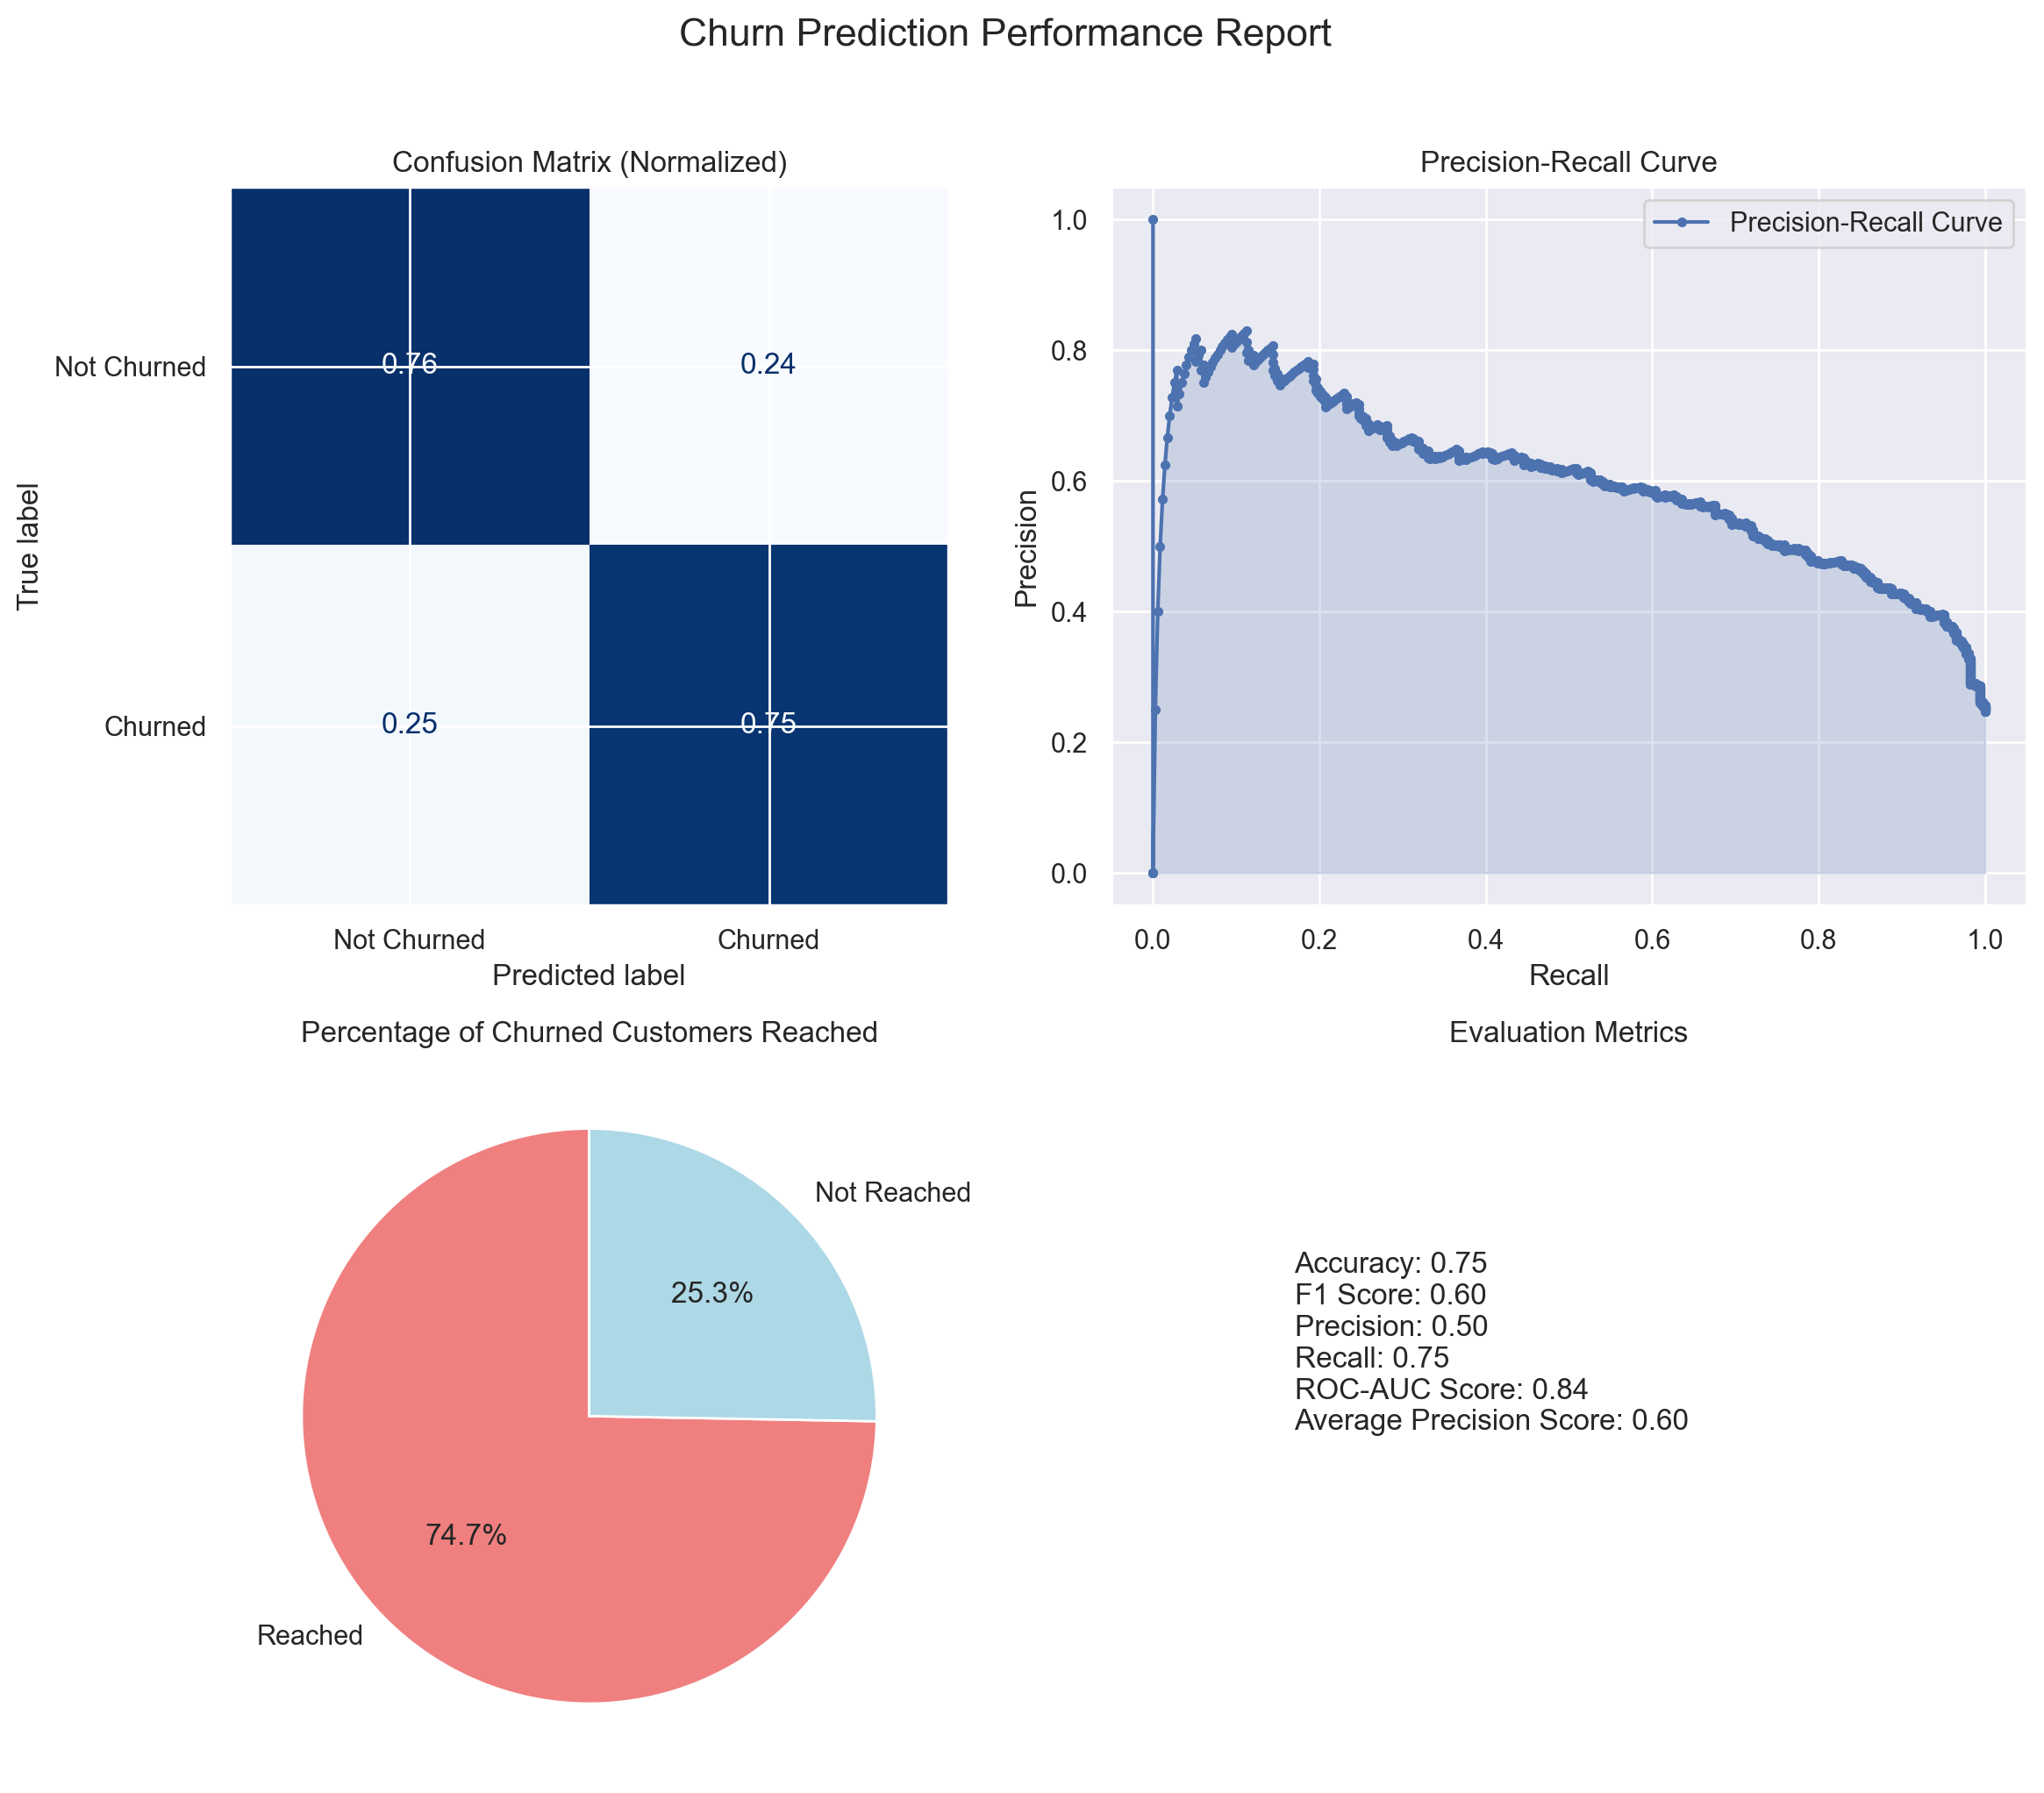

In [14]:
churn_performance_report(y_test, test_pred, y_pred_proba=y_probs)